# Animal Vision - Image Classification [Experiment Notebook]

In this project, we will be implementing a Image Classification problem using the PyTorch library. The dataset for this project is been collected from kaggle you can click [here](https://www.kaggle.com/datasets/jerrinbright/cheetahtigerwolf) to check the dataset for complete details. Dataset contains images of the animals. It's a simple dataset which is well scraped from the internet, animals are segregated in their respective directories, which is pretty much the standard way of creating a dataset in the Image Classification problem.

**Objective** - There are two objective for this project: 
 1. Perform different experiments on the dataset and use transfer learning to imporve the model performance (Experiment Notebook).
 2. When the model experiment is over move towards implementing the model onto production stage (Deployment Notebook).

# Section-1: Baseline Experiments

## Data Collection

Here will download the dataset from kaggle. 

To download a dataset from kaggle you need to have an API username and key generated from the kaggle account. Once you have a .json file you can download the dataset using the command mentioned in the data page.

In this experiment we will start small and only work with three animals, later we will be working on the complete dataset. First we will split the dataset into train and val directories and then move onto model stage.

In [1]:
# Import libraries
import os
import shutil
from pathlib import Path
!pip install -q split-folders
import splitfolders
import random
from tqdm.auto import tqdm
from timeit import default_timer as timer
import pandas as pd
!pip install -q opendatasets
import opendatasets as od

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
!pip install -q torchinfo
import torchinfo
from torchinfo import summary
!pip install -q torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy

import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

In [2]:
# setting up device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
# Download the dataset, uncomment to use this command.
# !cp "kaggle.json" -p ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# downloading into the data directory
data_path = Path('temp_data')
if data_path.exists():
    print(f'{data_path} directory exist')
else:
    print('Downloading data...')
    !kaggle datasets download -d jerrinbright/cheetahtigerwolf -p temp_data --unzip

100%|██████████████████████████████████████▉| 2.50G/2.51G [00:19<00:00, 103MB/s]
100%|███████████████████████████████████████| 2.51G/2.51G [00:19<00:00, 135MB/s]


In [24]:
# Copying three classes data from the raw data
raw_data = Path('temp_data/ANIMALS/ANIMALS')
animal_3classes_path = Path('temp_data/animal_data')
animal_list = ['LION', 'TIGER', 'WOLF']
if animal_3classes_path.exists():
    print(f'{raw_data} directory exist')
else:
    print('Copying raw data...')
    for i in animal_list:
        shutil.copytree(raw_data / i, animal_3classes_path / i)
        print(f'{i} directory created and files copied in "{animal_3classes_path/i}"')

Copying raw data...
LION directory created and files copied in "temp_data/animal_data/LION"
TIGER directory created and files copied in "temp_data/animal_data/TIGER"
WOLF directory created and files copied in "temp_data/animal_data/WOLF"


In [25]:
# Splitting the data in Train Test Split in ratio(80:20).
split_data_path = Path('temp_data/split_data')
if split_data_path.exists():
    print('Split directory exist...')
else:
    print('Spliting data in Train and Test set')
    splitfolders.ratio(animal_3classes_path, split_data_path, 42, (0.80, 0.20))

Spliting data in Train and Test set


Copying files: 2432 files [00:06, 368.18 files/s]


In [26]:
# Directory walkthrough
for dirpath, dirnames, filenames in os.walk(split_data_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} files in "{dirpath}"')

There are 2 directories and 0 files in "temp_data/split_data"
There are 3 directories and 0 files in "temp_data/split_data/train"
There are 0 directories and 724 files in "temp_data/split_data/train/WOLF"
There are 0 directories and 644 files in "temp_data/split_data/train/LION"
There are 0 directories and 576 files in "temp_data/split_data/train/TIGER"
There are 3 directories and 0 files in "temp_data/split_data/val"
There are 0 directories and 181 files in "temp_data/split_data/val/WOLF"
There are 0 directories and 162 files in "temp_data/split_data/val/LION"
There are 0 directories and 145 files in "temp_data/split_data/val/TIGER"


In [27]:
# train and test path
train_path = split_data_path / 'train'
test_path = split_data_path / 'val'
train_path, test_path

(PosixPath('temp_data/split_data/train'),
 PosixPath('temp_data/split_data/val'))

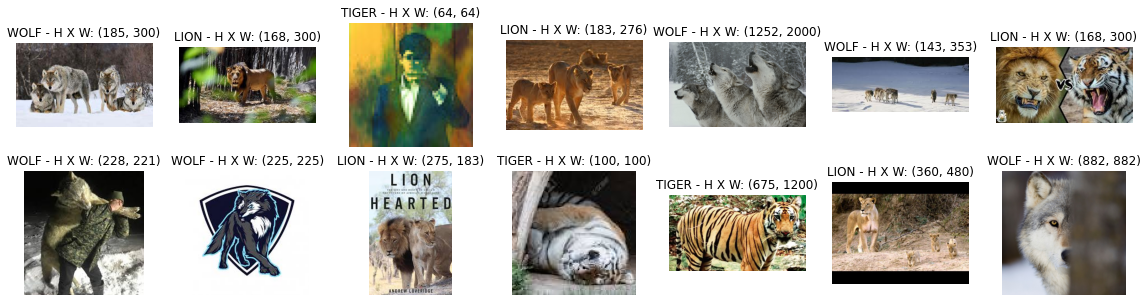

In [28]:
# Visualize random image
plt.figure(figsize=(20,5))
image_path_list = list(split_data_path.glob('*/*/*.jpg'))
for i in range(14):
    plt.subplot(2,7,i+1)
    rand_img_path = random.choice(image_path_list)
    image_class = rand_img_path.parent.stem
    img = plt.imread(rand_img_path)
    plt.imshow(img)
    plt.title(f'{image_class} - H X W: {img.shape[:2]}')
    plt.axis(False);

## Baseline Model

This is our first model, we will be going simple and creating a small model and smaller image dataset this will help in running the model training much faster but at the cost of quality.

In [30]:
# Baseline transform
baseline_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [31]:
# Load and transform data
train_data_baseline = datasets.ImageFolder(train_path, baseline_transform, )
test_data_baseline = datasets.ImageFolder(test_path, baseline_transform)
class_names = train_data_baseline.classes

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f'Dataloader with batch size: {BATCH_SIZE} and workers: {NUM_WORKERS}')

# Create Dataloaders
train_dataloaders_baseline = DataLoader(dataset=train_data_baseline,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloaders_baseline = DataLoader(dataset=test_data_baseline,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)
train_dataloaders_baseline, test_dataloaders_baseline

Dataloader with batch size: 32 and workers: 8


(<torch.utils.data.dataloader.DataLoader at 0x7f0310ab6760>,
 <torch.utils.data.dataloader.DataLoader at 0x7f02fc85c5e0>)

In [51]:
# Creating our baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int) -> None:
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*16*16,
                      output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_0 = BaselineModel(input_shape=3, output_shape=len(class_names), hidden_units=20).to(device)
model_0, summary(model_0, (1, 3, 64, 64))

(BaselineModel(
   (conv_block1): Sequential(
     (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_block2): Sequential(
     (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=5120, out_features=3, bias=True)
   )
 ),
 Layer (type:depth-idx)                   Output Shape              Param #
 BaselineModel                            [1, 3]                    --
 ├─Sequential: 1-1                        [1, 20, 32, 32]           --
 │    └─Conv

Single image shape: torch.Size([1, 3, 64, 64])

Output Logits:
tensor([[ 0.0059,  0.0372, -0.0008]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3306, 0.3411, 0.3284]], device='cuda:0')

Actual Label: (2, 'WOLF') and Predicted Label: (1, 'TIGER')


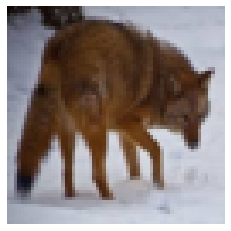

In [52]:
# Testing the model with a single image
img_batch, label_batch = next(iter(train_dataloaders_baseline)) # single batch of train data
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f'Single image shape: {img_single.shape}\n')
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    pred_prob = torch.softmax(pred, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)
print(f'Output Logits:\n{pred}\n')
print(f'Output prediction probabilities:\n{pred_prob}\n')
print(f'Actual Label: {label_single.item(), class_names[label_single]} and Predicted Label: {pred_label.item(), class_names[pred_label]}')
plt.imshow(img_single.squeeze(dim=0).permute(1,2,0))
plt.axis(False);

In [53]:
# Train and Test loop function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn: torchmetrics.classification.MulticlassAccuracy,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # forward pass
        y_pred = model(X)
        # loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += accuracy_fn(y_pred_class, y).item()
    # backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Calculate the loss and accuracy for the model
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn: torchmetrics.classification.MulticlassAccuracy):
    model.eval()
    test_loss, test_acc = 0, 0
    # Turn on inference context manager
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            # forward pass
            test_pred_logits = model(X)
            # loss and accuracy
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += accuracy_fn(test_pred_labels, y).item()
        # Calculate the loss and accuracy for the model
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    return test_loss, test_acc

In [54]:
# creating a function to run the training loop and testing result
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          accuracy_fn: torchmetrics.classification.MulticlassAccuracy,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5):
    # Creating a result dict.
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # Training and evaluation loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           accuracy_fn=accuracy_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn)
        print(f'Epoch: {epoch+1} | train_loss: {train_loss:.4f} , train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f}, test_acc: {test_acc:.4f}')
        # store every epoch results.
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
    return results

In [55]:
# train and evaluate baseline model
torch.manual_seed(42)
NUM_EPOCHS = 10

# creating loss, accuracy and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)

# Train model_0
model0_start_time = timer()

model_0_results = train(model_0,
                        train_dataloaders_baseline,
                        test_dataloaders_baseline,
                        loss_fn,
                        accuracy_fn,
                        optimizer,
                        NUM_EPOCHS)
model_0_end_time = timer()
print(f'\nTotal Training Time: {model_0_end_time - model0_start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0999 , train_acc: 0.0055 | test_loss: 2.0008, test_acc: 0.1250
Epoch: 2 | train_loss: 1.9643 , train_acc: 0.0055 | test_loss: 1.1030, test_acc: 0.1250
Epoch: 3 | train_loss: 1.1009 , train_acc: 0.0055 | test_loss: 1.0951, test_acc: 0.1458
Epoch: 4 | train_loss: 1.0989 , train_acc: 0.0055 | test_loss: 1.0926, test_acc: 0.1458
Epoch: 5 | train_loss: 1.0972 , train_acc: 0.0055 | test_loss: 1.9569, test_acc: 0.1458
Epoch: 6 | train_loss: 2.0015 , train_acc: 0.0055 | test_loss: 1.1299, test_acc: 0.1250
Epoch: 7 | train_loss: 1.1285 , train_acc: 0.0055 | test_loss: 1.1003, test_acc: 0.1033
Epoch: 8 | train_loss: 1.0996 , train_acc: 0.0055 | test_loss: 1.1009, test_acc: 0.1042
Epoch: 9 | train_loss: 1.1003 , train_acc: 0.0055 | test_loss: 1.1014, test_acc: 0.1042
Epoch: 10 | train_loss: 1.1008 , train_acc: 0.0055 | test_loss: 1.1016, test_acc: 0.1042

Total Training Time: 46.882 seconds


In [56]:
# Plot loss and accuracy curves
def plot_curves(model_result: dict):
    # Get loss values
    train_loss = model_result['train_loss']
    test_loss = model_result['test_loss']
  
    # get accuracy values
    train_accuracy = model_result['train_acc']
    test_accuracy = model_result['test_acc']
  
    # get total epochs
    epochs = range(len(model_result['train_loss']))
  
    # plot the curves
    plt.figure(figsize=(15, 7))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

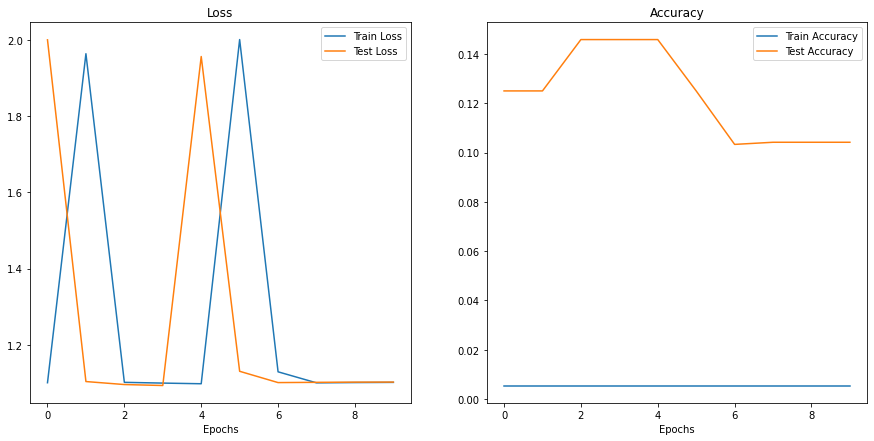

In [57]:
plot_curves(model_0_results)

Looking at the plot we can learn that the model is traning well with the dataset, but overfitting due the simiplicity of the model and less epochs for model training.

## Baseline Model with Data Augmentation

Lets try something different this time, to improve the model performance and decrease the overfitting while training we will introduce augmentation to the dataset. We will use TrivialAugmentWide which has a good reputation and backed by PyTorch team, you can read it [here](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#trivialaugment).

In [58]:
# Training transform with TrivalAugment
train_baseline_aug_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [59]:
# create train and test datasets and dataloaders for our data augment baseline model
torch.manual_seed(42)

train_baseline_dataaug = datasets.ImageFolder(train_path, transform=train_baseline_aug_transform)
test_baseline_dataaug = datasets.ImageFolder(test_path, transform=test_transform)

train_dataloader_dataaug = DataLoader(dataset=train_baseline_dataaug,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       num_workers=NUM_WORKERS)
test_dataloader_dataaug = DataLoader(dataset=test_baseline_dataaug,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)
print(f'{train_baseline_dataaug}\n{test_baseline_dataaug}\n{train_dataloader_dataaug}\n{test_dataloader_dataaug}')

Dataset ImageFolder
    Number of datapoints: 1944
    Root location: temp_data/split_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 488
    Root location: temp_data/split_data/val
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [60]:
# construct baseline model with data augmentation.
torch.manual_seed(42)
model_1 = BaselineModel(input_shape=3,
                        output_shape=len(class_names),
                        hidden_units=20).to(device)
model_1, summary(model_1, (1, 3, 64, 64))

(BaselineModel(
   (conv_block1): Sequential(
     (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_block2): Sequential(
     (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=5120, out_features=3, bias=True)
   )
 ),
 Layer (type:depth-idx)                   Output Shape              Param #
 BaselineModel                            [1, 3]                    --
 ├─Sequential: 1-1                        [1, 20, 32, 32]           --
 │    └─Conv

In [61]:
# Setting up the model training
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS=10

# Loss, accuracy and optimizer
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

# training the model
model1_start_time = timer()
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_dataaug,
                        test_dataloader=test_dataloader_dataaug,
                        loss_fn=loss_fn,
                        accuracy_fn=accuracy_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS)
model1_end_time = timer()
print(f'\nTotal Training Time: {model1_end_time - model1_start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0999 , train_acc: 0.0055 | test_loss: 2.3772, test_acc: 0.1250
Epoch: 2 | train_loss: 2.3065 , train_acc: 0.0055 | test_loss: 1.1094, test_acc: 0.1121
Epoch: 3 | train_loss: 1.1051 , train_acc: 0.0061 | test_loss: 1.1131, test_acc: 0.1042
Epoch: 4 | train_loss: 1.1150 , train_acc: 0.0055 | test_loss: 1.1009, test_acc: 0.1259
Epoch: 5 | train_loss: 1.1002 , train_acc: 0.0066 | test_loss: 1.0975, test_acc: 0.1328
Epoch: 6 | train_loss: 1.0979 , train_acc: 0.0025 | test_loss: 1.0872, test_acc: 0.1458
Epoch: 7 | train_loss: 1.0963 , train_acc: 0.0055 | test_loss: 1.0928, test_acc: 0.1536
Epoch: 8 | train_loss: 1.0964 , train_acc: 0.0060 | test_loss: 1.0761, test_acc: 0.2029
Epoch: 9 | train_loss: 1.0832 , train_acc: 0.0085 | test_loss: 1.0876, test_acc: 0.1155
Epoch: 10 | train_loss: 1.0956 , train_acc: 0.0067 | test_loss: 1.1648, test_acc: 0.1530

Total Training Time: 47.680 seconds


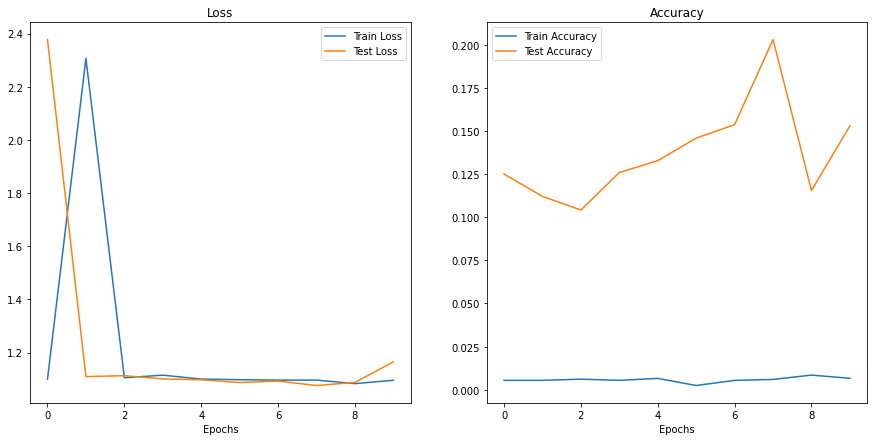

In [62]:
# plot the curves
plot_curves(model_1_results)

Once again we can see that the model is having diffuculty in getting good result even though we introduced augmentation.

## Compare model results

Now that we have trained two model which are quite similar in architecture and training hyperparameters.

We can compare both of the model results and look for some more insights.

In [64]:
# Compare our baseline model with and without augmentation
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.099888,0.005464,2.000785,0.125000
1,1.964302,0.005464,1.102984,0.125000
2,1.100889,0.005464,1.095113,0.145833
3,1.098924,0.005464,1.092596,0.145833
4,1.097204,0.005464,1.956930,0.145833
5,2.001457,0.005464,1.129938,0.125000
6,1.128545,0.005464,1.100258,0.103299
7,1.099566,0.005464,1.100910,0.104167
8,1.100339,0.005464,1.101437,0.104167
9,1.100786,0.005464,1.101596,0.104167


In [65]:
# plot to compare our baseline results
def model_curves_compare(model0_df: pd.DataFrame,
                         model1_df: pd.DataFrame):
    plt.figure(figsize=(15, 10))
    epochs=range(len(model0_df))
    # plot train loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, model0_df['train_loss'], label='Model_0')
    plt.plot(epochs, model1_df['train_loss'], label='Model_1')
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # plot test loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, model0_df['test_loss'], label='Model_0')
    plt.plot(epochs, model1_df['test_loss'], label='Model_1')
    plt.title('Test Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # plot train accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, model0_df['train_acc'], label='Model_0')
    plt.plot(epochs, model1_df['train_acc'], label='Model_1')
    plt.title('Train Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    # plot test accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, model0_df['test_acc'], label='Model_0')
    plt.plot(epochs, model1_df['test_acc'], label='Model_1')
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

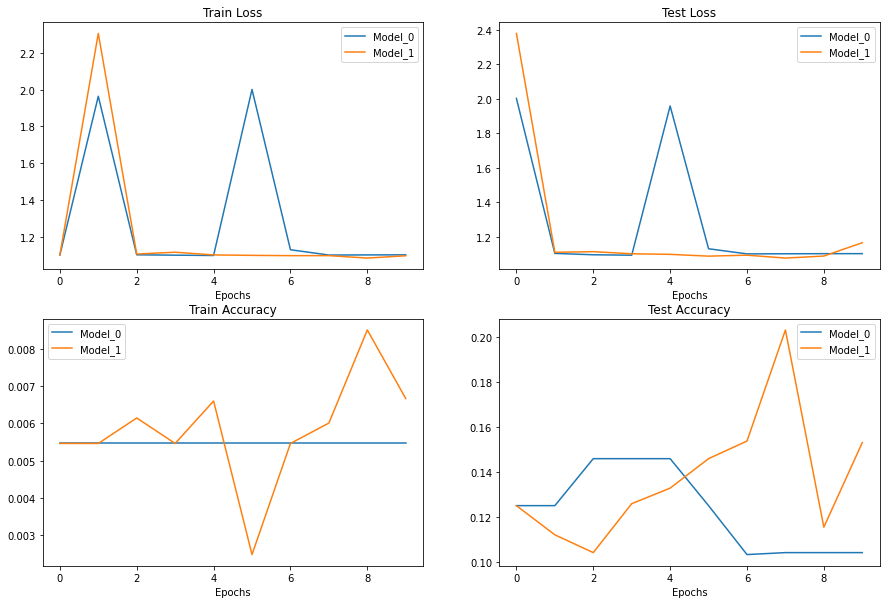

In [66]:
model_curves_compare(model0_df=model_0_df,
                     model1_df=model_1_df)

Comparing we can see a clear picture of the model training done with and without augmentation.

Durning model training with augmentation, gradients were actually improving and there's a possibility that if we run for more epochs the model will yield better result then the current ones.

## Testing our Model

Lets check how the model works on unknown data and visualize the result.

In [67]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names=None,
                        transform=None,
                        device=device):
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.
    if transform:
        target_image = transform(target_image)
    model.to(device)
    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)
        target_image_pred = model(target_image.to(device))
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names:
        title=f'Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}'
    else:
        title=f'Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}'
    plt.title(title)
    plt.axis(False);

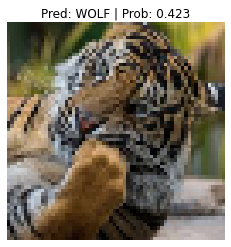

In [78]:
test_image_list = list(test_path.glob('*/*.jpg'))
random_image = random.choice(test_image_list)

transform_custom_image = transforms.Compose([
    transforms.Resize((64, 64))
])

pred_and_plot_image(model=model_1,
                    image_path=random_image,
                    class_names=class_names,
                    transform=transform_custom_image,
                    device=device)

I have ranned multiple times the random visualization, but every time the model has wrongly predicted most of the images.

We knew it would be this way, seeing the above training plot we can estimate that the model is just guessing on one of the classes to be all the images, in this case it is the wolf class.

---


# Section-2: Modelling Experiments

In this section we will be moving towards improving the model drastically and getting some serious results.

This results will help us in making some critical decision for our next objective. So lets start our experiment!

In [81]:
# import libraries
import os
import shutil
import random
from pathlib import Path
import torch
from torch import nn
import torchvision
from torchvision import transforms
!pip install -q torchinfo
from torchinfo import summary
import matplotlib.pyplot as plt
from helper_scripts import get_data
from model_scripts import data_setup, engine, utils, image_plot
import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

Requirement already satisfied: split-folders in /usr/local/lib/python3.9/dist-packages (0.5.1)

Requirement already satisfied: opendatasets in /usr/local/lib/python3.9/dist-packages (0.1.22)

Requirement already satisfied: tqdm in /usr/local/lib/python3.9/dist-packages (from opendatasets) (4.64.0)

Requirement already satisfied: click in /usr/local/lib/python3.9/dist-packages (from opendatasets) (8.1.3)

Requirement already satisfied: kaggle in /usr/local/lib/python3.9/dist-packages (from opendatasets) (1.5.12)

Requirement already satisfied: six>=1.10 in /usr/lib/python3/dist-packages (from kaggle->opendatasets) (1.14.0)

Requirement already satisfied: python-slugify in /usr/lib/python3/dist-packages (from kaggle->opendatasets) (4.0.0)

Requirement already satisfied: certifi in /usr/lib/python3/dist-packages (from kaggle->opendatasets) (2019.11.28)

Requirement already satisfied: urllib3 in /usr/local/lib/python3.9/dist-packages (from kaggle->opendatasets) (1.26.10)

Requirement already satisfied: requests in /usr/local/lib/python3.9/dist-packages (from kaggle->opendatasets) (2.28.1)

Requirement already satisfied: python-dateutil in /usr/local/lib/python3.9/dist-packages (from kaggle->opendatasets) (2.8.2)

Requirement already satisfied: charset-normalizer<3,>=2 in /usr/local/lib/python3.9/dist-packages (from requests->kaggle->opendatasets) (2.1.0)

Requirement already satisfied: idna<4,>=2.5 in /usr/lib/python3/dist-packages (from requests->kaggle->opendatasets) (2.8)

WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv


In [82]:
# function for seed
def set_seeds(seed: int=42):
    """
    Set random seed for torch operations.
    Args: seed: Random integer for seed. Default is 42.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [83]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
# download data
get_data.download_data()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: johnp47
Your Kaggle Key: ··········


100%|██████████| 2.51G/2.51G [00:23<00:00, 116MB/s]




Copying raw data...
LION directory created and files copied in "temp_data/animal_data/LION"
TIGER directory created and files copied in "temp_data/animal_data/TIGER"
WOLF directory created and files copied in "temp_data/animal_data/WOLF"

Spliting data in Train and Test set


Copying files: 2432 files [00:01, 2326.39 files/s]



temp_data directory is deleted


## Feature Extractor Models

We will be using the helper scripts and model scripts for quickly downloading and training our experiments.

In this section we will be using the technique called transfer learning, where we will be using different pre-trained nerural networks to get some state of the art results.

In [6]:
# data directory
train_dir = Path("data/lion_tiger_wolf/train")
test_dir = Path("data/lion_tiger_wolf/val")

# Create transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# create dataloaders
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=transform,
                                                                               batch_size=32)
transform, len(train_dataloader), len(test_dataloader), class_names

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ), 61, 16, ['LION', 'TIGER', 'WOLF'])

We will be experimenting with three different pre-trained models:
 1. EfficientNetB2
 2. ResNet50
 3. ConvNeXt_Tiny

In [ ]:
# Create function for EfficientNetB2
def create_effnetb2():
    # setup pretrained weights and model instance
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    # Freeze the model layers
    for param in model.features.parameters():
        param.requires_grad = False
    # set seed
    set_seeds()
    # change the classifier
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=len(class_names))).to(device)
    # model name
    model.name = 'effnetb0'
    print(f'[INFO] Created new {model.name} model\n')
    return model

# Create function for ResNet50
def create_resnet50():
    # setup pretrained weights and model instance
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    model = torchvision.models.resnet50(weights=weights).to(device)
    # Freeze the base model layers
    for param in model.parameters():
        param.requires_grad = False
    # set seed
    set_seeds()
    # change the classifier
    model.fc = nn.Linear(in_features=2048, out_features=len(class_names)).to(device)
    # model name
    model.name = 'resnet50'
    print(f'[INFO] Created new {model.name} model\n')
    return model

# Create function for ConvNeXt_Tiny
def create_convnext_tiny():
    # setup pretrained weights and model instance
    weights = torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT
    model = torchvision.models.convnext_tiny(weights=weights).to(device)
    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
    # set seed
    set_seeds()
    # change the classifier
    model.classifier[2] = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
    # model name
    model.name = 'convnext_tiny'
    print(f'[INFO] Created new {model.name} model\n')
    return model

In [ ]:
# create a model with custom head
effnetb2 = create_effnetb2()
resnet50 = create_resnet50()
convnext_tiny = create_convnext_tiny()

# summary of the models
print(summary(effnetb2, (32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names']), f'\n',
summary(resnet50, (32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names']), f'\n',
summary(convnext_tiny, (32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names']))

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

[INFO] Created new effnetb0 model



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

[INFO] Created new resnet50 model



Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

[INFO] Created new convnext_tiny model

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                          

Now, we will run a series of training for all the pre-trained model for certain number of epochs.

In [ ]:
%%time
set_seeds(42)

# epochs list
num_epochs = [5, 10]

# model list
models = ['effnetb2', 'resnet50', 'convnext_tiny']

# To keep track of all the elements
experiment_number = 0

# loop through each epochs
for epoch in num_epochs:
    # loop through each model
    for model_name in models:
        # print information
        experiment_number += 1
        print(f'\n[INFO] Experiment Number: {experiment_number}')
        print(f'[INFO] Model: {model_name}')
        print(f'[INFO] Number of Epochs: {epoch}')
        # select the model and create it everytime
        if model_name == 'effnetb2':
            model = create_effnetb2()
        elif model_name == 'resnet50':
            model = create_resnet50()
        else:
            model = create_convnext_tiny()
        # loss and optimizer function
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),
                                     lr=0.001)
        # training the model
        result = engine.train(model,
                              train_dataloader,
                              test_dataloader,
                              loss_fn,
                              optimizer,
                              epoch,
                              device,
                              engine.create_writer('animal_vision_3classes',
                                                    model_name,
                                                    f'{epoch}_epochs'))
        # save the model
        save_filepath = f'animal_vision_3classes_{model_name}_{epoch}epochs.pth'
        utils.save_model(model,
                         'models',
                         save_filepath)
        print('-'*100 + '\n')


[INFO] Experiment Number: 1
[INFO] Model: effnetb2
[INFO] Number of Epochs: 5
[INFO] Created new effnetb0 model


[INFO] Creating SummaryWriter, saving to: runs/04-12-2022/animal_vision_3classes/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5659 , train_acc: 0.8250 | test_loss: 0.2771, test_acc: 0.9238
Epoch: 2 | train_loss: 0.3092 , train_acc: 0.8992 | test_loss: 0.2198, test_acc: 0.9434
Epoch: 3 | train_loss: 0.2582 , train_acc: 0.9160 | test_loss: 0.1948, test_acc: 0.9453
Epoch: 4 | train_loss: 0.2418 , train_acc: 0.9209 | test_loss: 0.1753, test_acc: 0.9434
Epoch: 5 | train_loss: 0.2323 , train_acc: 0.9167 | test_loss: 0.1745, test_acc: 0.9434

[INFO] Saving Model to: models/animal_vision_3classes_effnetb2_5epochs.pth
--------------------------------------------------


[INFO] Experiment Number: 2
[INFO] Model: resnet50
[INFO] Number of Epochs: 5
[INFO] Created new resnet50 model


[INFO] Creating SummaryWriter, saving to: runs/04-12-2022/animal_vision_3classes/resnet50/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5592 , train_acc: 0.8470 | test_loss: 0.2890, test_acc: 0.9297
Epoch: 2 | train_loss: 0.2656 , train_acc: 0.9322 | test_loss: 0.2088, test_acc: 0.9375
Epoch: 3 | train_loss: 0.2086 , train_acc: 0.9378 | test_loss: 0.1817, test_acc: 0.9434
Epoch: 4 | train_loss: 0.1770 , train_acc: 0.9518 | test_loss: 0.1688, test_acc: 0.9336
Epoch: 5 | train_loss: 0.1650 , train_acc: 0.9474 | test_loss: 0.1579, test_acc: 0.9473

[INFO] Saving Model to: models/animal_vision_3classes_resnet50_5epochs.pth
--------------------------------------------------


[INFO] Experiment Number: 3
[INFO] Model: convnext_tiny
[INFO] Number of Epochs: 5
[INFO] Created new convnext_tiny model


[INFO] Creating SummaryWriter, saving to: runs/04-12-2022/animal_vision_3classes/convnext_tiny/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3136 , train_acc: 0.9122 | test_loss: 0.1116, test_acc: 0.9648
Epoch: 2 | train_loss: 0.1214 , train_acc: 0.9575 | test_loss: 0.0953, test_acc: 0.9688
Epoch: 3 | train_loss: 0.0992 , train_acc: 0.9614 | test_loss: 0.0899, test_acc: 0.9707
Epoch: 4 | train_loss: 0.0911 , train_acc: 0.9682 | test_loss: 0.0859, test_acc: 0.9590
Epoch: 5 | train_loss: 0.0830 , train_acc: 0.9693 | test_loss: 0.0844, test_acc: 0.9688

[INFO] Saving Model to: models/animal_vision_3classes_convnext_tiny_5epochs.pth
--------------------------------------------------


[INFO] Experiment Number: 4
[INFO] Model: effnetb2
[INFO] Number of Epochs: 10
[INFO] Created new effnetb0 model


[INFO] Creating SummaryWriter, saving to: runs/04-12-2022/animal_vision_3classes/effnetb2/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5659 , train_acc: 0.8250 | test_loss: 0.2771, test_acc: 0.9238
Epoch: 2 | train_loss: 0.3092 , train_acc: 0.8992 | test_loss: 0.2198, test_acc: 0.9434
Epoch: 3 | train_loss: 0.2582 , train_acc: 0.9160 | test_loss: 0.1948, test_acc: 0.9453
Epoch: 4 | train_loss: 0.2418 , train_acc: 0.9209 | test_loss: 0.1753, test_acc: 0.9434
Epoch: 5 | train_loss: 0.2323 , train_acc: 0.9167 | test_loss: 0.1745, test_acc: 0.9434
Epoch: 6 | train_loss: 0.2123 , train_acc: 0.9276 | test_loss: 0.1603, test_acc: 0.9375
Epoch: 7 | train_loss: 0.2079 , train_acc: 0.9261 | test_loss: 0.1577, test_acc: 0.9375
Epoch: 8 | train_loss: 0.2008 , train_acc: 0.9278 | test_loss: 0.1618, test_acc: 0.9297
Epoch: 9 | train_loss: 0.1875 , train_acc: 0.9329 | test_loss: 0.1540, test_acc: 0.9434
Epoch: 10 | train_loss: 0.1820 , train_acc: 0.9305 | test_loss: 0.1586, test_acc: 0.9453

[INFO] Saving Model to: models/animal_vision_3classes_effnetb2_10epochs.pth
------------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5592 , train_acc: 0.8470 | test_loss: 0.2890, test_acc: 0.9297
Epoch: 2 | train_loss: 0.2656 , train_acc: 0.9322 | test_loss: 0.2088, test_acc: 0.9375
Epoch: 3 | train_loss: 0.2086 , train_acc: 0.9378 | test_loss: 0.1817, test_acc: 0.9434
Epoch: 4 | train_loss: 0.1770 , train_acc: 0.9518 | test_loss: 0.1688, test_acc: 0.9336
Epoch: 5 | train_loss: 0.1650 , train_acc: 0.9474 | test_loss: 0.1579, test_acc: 0.9473
Epoch: 6 | train_loss: 0.1411 , train_acc: 0.9578 | test_loss: 0.1529, test_acc: 0.9336
Epoch: 7 | train_loss: 0.1278 , train_acc: 0.9648 | test_loss: 0.1502, test_acc: 0.9355
Epoch: 8 | train_loss: 0.1222 , train_acc: 0.9631 | test_loss: 0.1478, test_acc: 0.9355
Epoch: 9 | train_loss: 0.1173 , train_acc: 0.9617 | test_loss: 0.1389, test_acc: 0.9355
Epoch: 10 | train_loss: 0.1087 , train_acc: 0.9682 | test_loss: 0.1429, test_acc: 0.9336

[INFO] Saving Model to: models/animal_vision_3classes_resnet50_10epochs.pth
------------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3136 , train_acc: 0.9122 | test_loss: 0.1116, test_acc: 0.9648
Epoch: 2 | train_loss: 0.1214 , train_acc: 0.9575 | test_loss: 0.0953, test_acc: 0.9688
Epoch: 3 | train_loss: 0.0992 , train_acc: 0.9614 | test_loss: 0.0899, test_acc: 0.9707
Epoch: 4 | train_loss: 0.0911 , train_acc: 0.9682 | test_loss: 0.0859, test_acc: 0.9590
Epoch: 5 | train_loss: 0.0830 , train_acc: 0.9693 | test_loss: 0.0844, test_acc: 0.9688
Epoch: 6 | train_loss: 0.0774 , train_acc: 0.9708 | test_loss: 0.0874, test_acc: 0.9590
Epoch: 7 | train_loss: 0.0715 , train_acc: 0.9723 | test_loss: 0.0814, test_acc: 0.9609
Epoch: 8 | train_loss: 0.0688 , train_acc: 0.9725 | test_loss: 0.0795, test_acc: 0.9688
Epoch: 9 | train_loss: 0.0627 , train_acc: 0.9776 | test_loss: 0.0792, test_acc: 0.9688
Epoch: 10 | train_loss: 0.0618 , train_acc: 0.9768 | test_loss: 0.0804, test_acc: 0.9629

[INFO] Saving Model to: models/animal_vision_3classes_convnext_tiny_10epochs.pth
-------------------------------------

In [ ]:
# Viewing all the result on tensorboard
# %load_ext tensorboard
# %tensorboard --logdir ./runs

Looking at the model result, we can say that the EfficientNetB2 model has shown a really intresting result.

The best performing model is ConvNeXt_Tiny with a accuracy of 96%, but if you check the model size to model results then EfficientNetB2 wins over here. 

EfficientNetB2 model is light weight while the other two model are 3x size larger, still the EfficientNetB2 has shown almost same or better result as ResNet50 and slightly less than ConvNeXt_Tiny. 

In [ ]:
# Loading the best model and predicting image on it.
# setup the model path
best_model_path = 'models/animal_vision_3classes_effnetb2_10epochs.pth'

# Instantiate a new instance of the model
effnetb2 = create_effnetb2()

#  Loading the model
effnetb2.load_state_dict(torch.load(best_model_path))

# check the model size
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f'Total size of the model {effnetb2_model_size} MB')

[INFO] Created new effnetb0 model

Total size of the model 29 MB


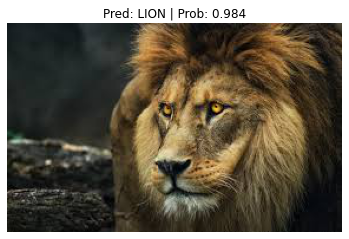

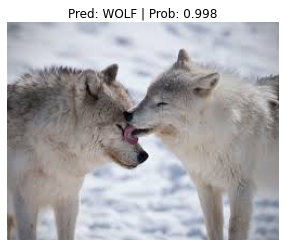

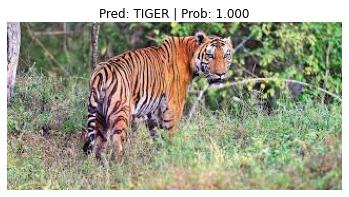

In [ ]:
# pred and plot random test image
num_img_plot = 3
test_img_list = list(test_dir.glob('*/*.jpg'))
test_img_sample = random.sample(population=test_img_list,
                                k=num_img_plot)
for img_path in test_img_sample:
    image_plot.pred_and_plot_image(model=effnetb2,
                                   image_path=img_path,
                                   class_names=class_names,
                                   image_size=(224, 224),
                                   device=device)

Look at the result we are getting from EfficientNetB2 model. Really Impressive!

EfficientNetB2 is able to give us 98-100% correct probability for the image classification. 

## Vision Transformer(ViT)

We will also look at the Vision Transformer model, which is currently one of the state of the art models that is capable to produce really great results compare to the traditional image classification models. 

ViT uses the methodology of the Natural Language Processing (NLP) where the transformer like architecture is employed over the patches of the images and then those patches are embedded and these embeddings are provided to the transformer encoders.

In [7]:
# creating a new dataloader
torch.manual_seed(42)

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

vit_train_dataloader, vit_test_dataloader, vit_class_names = data_setup.create_dataloaders(train_dir,
                                                                                           test_dir,
                                                                                           simple_transform,
                                                                                           32)

In [8]:
# Getting a single image from our dataloader
image_batch, label_batch = next(iter(vit_train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

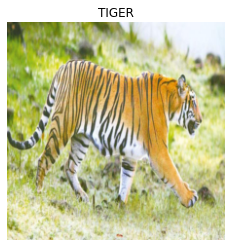

In [ ]:
plt.imshow(image.permute(1, 2, 0))
plt.title(vit_class_names[label])
plt.axis(False);

In [ ]:
# Calculating patch embedding shapes
HEIGHT = 224
WIDTH = 224
COLOR_CHANNELS = 3
PATCH_SIZE = 16

# Calculate number of patches - manual
number_of_patches = int((HEIGHT * WIDTH) / PATCH_SIZE**2)
patch_shape = (number_of_patches, (PATCH_SIZE**2)*COLOR_CHANNELS)
print(f'Number of patches (N) with image height (H={HEIGHT}), width (W={WIDTH}) and patch size (P={PATCH_SIZE}): {number_of_patches}\nPatch shape: {patch_shape}')

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196
Patch shape: (196, 768)


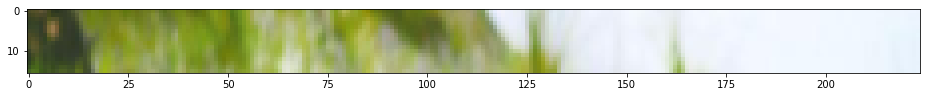

In [ ]:
# image in matplotlib format
image_permuted = image.permute(1, 2, 0)

# Index to plot top row as per patch size
plt.figure(figsize=(PATCH_SIZE, PATCH_SIZE))
plt.imshow(image_permuted[:PATCH_SIZE, :, :]);

Number of patches per row: 14
Patch size: 16 X 16 pixels


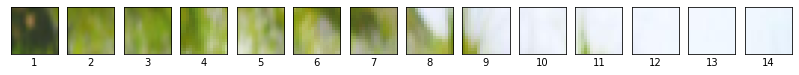

In [ ]:
# Create a patch plot
NUM_PATCHES = HEIGHT // PATCH_SIZE
print(f'Number of patches per row: {NUM_PATCHES}\nPatch size: {PATCH_SIZE} X {PATCH_SIZE} pixels')

fig, axs = plt.subplots(nrows=1,
                        ncols=NUM_PATCHES,
                        figsize=(NUM_PATCHES, NUM_PATCHES),
                        sharex=True,
                        sharey=True)
for i, patch in enumerate(range(0, HEIGHT, PATCH_SIZE)):
    axs[i].imshow(image_permuted[:PATCH_SIZE, patch:patch+PATCH_SIZE, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

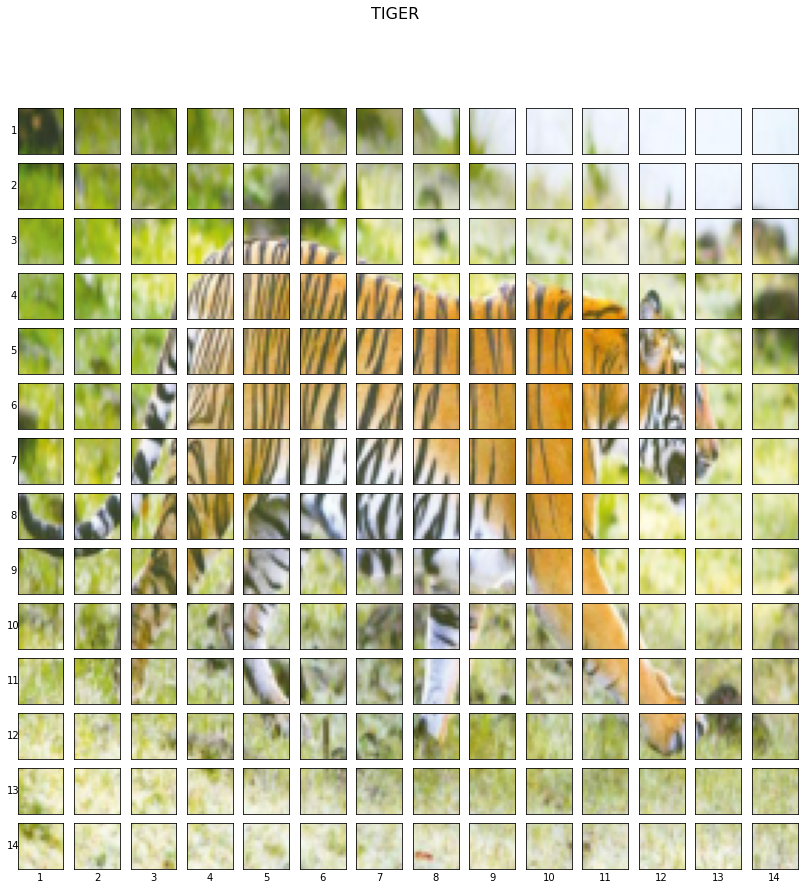

In [ ]:
# patch plot on whole image
fig, axs = plt.subplots(nrows=NUM_PATCHES,
                        ncols=NUM_PATCHES,
                        figsize=(NUM_PATCHES, NUM_PATCHES),
                        sharex=True,
                        sharey=True)
for i, patch_height in enumerate(range(0, HEIGHT, PATCH_SIZE)):
    for j, patch_width in enumerate(range(0, WIDTH, PATCH_SIZE)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+PATCH_SIZE, 
                                        patch_width:patch_width+PATCH_SIZE, :]);
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_ylabel(i+1,
                             rotation='horizontal',
                             horizontalalignment='center',
                             verticalalignment='center')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
fig.suptitle(f'{vit_class_names[label]}', fontsize=16)
plt.show()

## Using Pretrained ViT

In [8]:
# Getting pretrained weights of ViT pretrained model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Set up an instance of the ViT prepaid model using the above weights
vit_model = torchvision.models.vit_b_16(weights=vit_weights).to(device)

# freeze the models base parameters
for params in vit_model.parameters():
    params.requires_grad = False

# Change the classifier head
set_seeds()
vit_model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [9]:
summary(vit_model, (32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [10]:
# Training the ViT model
# creating optimizer and loss function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=1e-3)

# training the model using the engine.py script
num_epochs = [5, 10]
for epoch in num_epochs:
    vit_results = engine.train(model=vit_model,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               epochs=epoch,
                               device=device,
                               writer=engine.create_writer('animal_vision_3classes',
                                                           'vit_model',
                                                           f'{epoch}_epochs'))


[INFO] Creating SummaryWriter, saving to: runs/06-12-2022/animal_vision_3classes/vit_model/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2460 , train_acc: 0.9218 | test_loss: 0.1123, test_acc: 0.9590
Epoch: 2 | train_loss: 0.1181 , train_acc: 0.9606 | test_loss: 0.1054, test_acc: 0.9551
Epoch: 3 | train_loss: 0.0993 , train_acc: 0.9672 | test_loss: 0.1018, test_acc: 0.9531
Epoch: 4 | train_loss: 0.0890 , train_acc: 0.9715 | test_loss: 0.0981, test_acc: 0.9531
Epoch: 5 | train_loss: 0.0802 , train_acc: 0.9728 | test_loss: 0.0973, test_acc: 0.9531

[INFO] Creating SummaryWriter, saving to: runs/06-12-2022/animal_vision_3classes/vit_model/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0736 , train_acc: 0.9737 | test_loss: 0.0983, test_acc: 0.9531
Epoch: 2 | train_loss: 0.0690 , train_acc: 0.9728 | test_loss: 0.0979, test_acc: 0.9531
Epoch: 3 | train_loss: 0.0653 , train_acc: 0.9749 | test_loss: 0.0993, test_acc: 0.9531
Epoch: 4 | train_loss: 0.0624 , train_acc: 0.9754 | test_loss: 0.0999, test_acc: 0.9531
Epoch: 5 | train_loss: 0.0587 , train_acc: 0.9752 | test_loss: 0.0970, test_acc: 0.9570
Epoch: 6 | train_loss: 0.0574 , train_acc: 0.9763 | test_loss: 0.1003, test_acc: 0.9551
Epoch: 7 | train_loss: 0.0546 , train_acc: 0.9764 | test_loss: 0.0982, test_acc: 0.9551
Epoch: 8 | train_loss: 0.0544 , train_acc: 0.9778 | test_loss: 0.1026, test_acc: 0.9531
Epoch: 9 | train_loss: 0.0523 , train_acc: 0.9769 | test_loss: 0.1031, test_acc: 0.9512
Epoch: 10 | train_loss: 0.0504 , train_acc: 0.9785 | test_loss: 0.1058, test_acc: 0.9531


We can see that Vision Transformer is also capable to produce good result, similar to other pre-trained models.

Also, Vision Transformer model is the biggest model we have experimented. The model is 12x bigger then EfficientNetB2 model. 

---

# Animal30 Dataset

Now that we have gone through different models we can move forward with our second objective to deploy the models and check how does it perform in the original world outside the notebook.

For that we will be taking a big step and working with the full dataset. Animal30, a dataset containing 30 different animals scrapped from the internet.

While working on the 3 class dataset, I had noticed that there were dirty data present in the raw dataset. This needs to be cleaned for getting a really good result before deploying our model.

## Preprocessing the animal 30 dataset

In [7]:
# Downloading the full dataset from kaggle
big_data_url = 'https://www.kaggle.com/datasets/johnp47/raw-animals-image-dataset'
animal30_data_path = Path('data/animal30')
 
if animal30_data_path.exists():
    print(f'[INFO] Animal 30 Directory: "{animal30_data_path}" already exist. ')
else:
    od.download_kaggle_dataset(big_data_url,
                               animal30_data_path)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  johnp47


Your Kaggle Key:

  ································


100%|██████████| 1.82G/1.82G [00:36<00:00, 53.3MB/s]


When I looked at images that were misclassified they were not images of animals. 

I noticed these invalid images were small so I think I can filter them off by looking at the number of pixels in the image. 

Code below will detect images with less than min_area number of pixels

In [8]:
# Setting up the training and Validation path
animal30_train_dir = Path('data/animal30/raw-animals-image-dataset/train')
animal30_val_dir = Path('data/animal30/raw-animals-image-dataset/val')

# Maximum area of the bad images
min_area = 50 * 50

In [9]:
# Filtering bad images from the dataset using for loop.
bad_images = []
dirlist = [animal30_train_dir, animal30_val_dir]
names = ['train', 'val']
zip_dir = zip(names, dirlist)

for name, dir in zip_dir:
    filepaths=[]
    labels=[]
    classlist = sorted(os.listdir(dir))
    for animal_class in classlist:
        classpath = os.path.join(dir, animal_class)
        if os.path.isdir(classpath):
            file_list = sorted(os.listdir(classpath))
            desc = f'\nClass Name: {animal_class} | Directory: {name}'
            for f in tqdm(file_list, desc=desc, unit='files'):
                try:
                    fpath = os.path.join(classpath, f)
                    image = plt.imread(fpath)
                    # Calculating the image area
                    h = image.shape[0]
                    w = image.shape[1]
                    c = image.shape[2]
                    area = h * w
                    # Filtering by area
                    if area >= min_area:
                        filepaths.append(fpath)
                        labels.append(animal_class)
                    else:
                        bad_images.append(fpath)
                    # Filtering by color channels
                    if c != 3:
                        bad_images.append(fpath)
                except:
                    # All the exception images are bad format images or images with no color channels.
                    bad_images.append(fpath)
                    print(f'Exception files: {fpath}, Pixel Area: {area}, Image shape: {image.shape}\n')
print(f'There are total {len(bad_images)} bad images in the animal30 dataset.')


Class Name: BEAR | Directory: train:   0%|          | 0/734 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/BEAR/image.jpg, Pixel Area: 10000, Image shape: (350, 350)
Exception files: data/animal30/raw-animals-image-dataset/train/BEAR/image1.jpg, Pixel Area: 10000, Image shape: (350, 350)



Class Name: CATS | Directory: train:   0%|          | 0/709 [00:00<?, ?files/s]


Class Name: CHEETAH | Directory: train:   0%|          | 0/663 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/CHEETAH/_f648e15c-41a0-11ea-bfa0-35d85fc987f6.png, Pixel Area: 589824, Image shape: (576, 1024, 3)



Class Name: COW | Directory: train:   0%|          | 0/722 [00:00<?, ?files/s]


Class Name: CROCODILES | Directory: train:   0%|          | 0/640 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/CROCODILES/Untitled-design-442.png, Pixel Area: 422400, Image shape: (528, 800, 3)



Class Name: DEER | Directory: train:   0%|          | 0/736 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/DEER/image.jpg, Pixel Area: 10000, Image shape: (350, 350)



Class Name: DOGS | Directory: train:   0%|          | 0/780 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/DOGS/image.jpg, Pixel Area: 10000, Image shape: (350, 350)
Exception files: data/animal30/raw-animals-image-dataset/train/DOGS/image0.jpg, Pixel Area: 10000, Image shape: (350, 350)
Exception files: data/animal30/raw-animals-image-dataset/train/DOGS/image1.jpg, Pixel Area: 576, Image shape: (350, 350)



Class Name: ELEPHANT | Directory: train:   0%|          | 0/673 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/ELEPHANT/image.jpg, Pixel Area: 10000, Image shape: (350, 350)



Class Name: GIRAFFE | Directory: train:   0%|          | 0/692 [00:00<?, ?files/s]


Class Name: GOAT | Directory: train:   0%|          | 0/644 [00:00<?, ?files/s]


Class Name: HIPPOPOTAMUS | Directory: train:   0%|          | 0/728 [00:00<?, ?files/s]


Class Name: HORSE | Directory: train:   0%|          | 0/776 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/HORSE/_103224847_horsea.png, Pixel Area: 288350, Image shape: (395, 730, 3)



Class Name: KANGAROO | Directory: train:   0%|          | 0/665 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/KANGAROO/Untitled-design-103.png, Pixel Area: 360000, Image shape: (450, 800, 3)



Class Name: LION | Directory: train:   0%|          | 0/644 [00:00<?, ?files/s]


Class Name: MEERKAT | Directory: train:   0%|          | 0/686 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/MEERKAT/ylkmo-M9V60DRK8V3-Full-Image_GalleryBackground-en-US-1589484277579._SX1080_.png, Pixel Area: 3000000, Image shape: (2000, 1500, 3)



Class Name: MONKEY | Directory: train:   0%|          | 0/676 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/MONKEY/_35ac79e8-d41f-11e9-bf18-74205beb354d.png, Pixel Area: 339200, Image shape: (400, 848, 3)



Class Name: MOOSE | Directory: train:   0%|          | 0/687 [00:00<?, ?files/s]


Class Name: OSTRICH | Directory: train:   0%|          | 0/648 [00:00<?, ?files/s]


Class Name: PANDA | Directory: train:   0%|          | 0/676 [00:00<?, ?files/s]


Class Name: PENGUINS | Directory: train:   0%|          | 0/651 [00:00<?, ?files/s]


Class Name: PORCUPINE | Directory: train:   0%|          | 0/651 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/PORCUPINE/image.jpg, Pixel Area: 10000, Image shape: (350, 350)



Class Name: RABBIT | Directory: train:   0%|          | 0/669 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/RABBIT/SSEA11.png, Pixel Area: 921600, Image shape: (720, 1280, 3)



Class Name: RHINO | Directory: train:   0%|          | 0/618 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/RHINO/38523mhstjwd3uvwwhwf0y8ex2nkognkoiec7927574png.png, Pixel Area: 5402592, Image shape: (1924, 2808, 3)
Exception files: data/animal30/raw-animals-image-dataset/train/RHINO/image.jpg, Pixel Area: 862800, Image shape: (350, 350)
Exception files: data/animal30/raw-animals-image-dataset/train/RHINO/rhino.png, Pixel Area: 2304, Image shape: (48, 48, 4)



Class Name: SNAKE | Directory: train:   0%|          | 0/699 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/SNAKE/SNAKK.png, Pixel Area: 2620000, Image shape: (1310, 2000, 3)
Exception files: data/animal30/raw-animals-image-dataset/train/SNAKE/image.jpg, Pixel Area: 10000, Image shape: (350, 350)



Class Name: SQUIREL | Directory: train:   0%|          | 0/667 [00:00<?, ?files/s]


Class Name: TIGER | Directory: train:   0%|          | 0/576 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/TIGER/_0df30e3a-2aff-11ea-8266-2aa83479d6f9.png, Pixel Area: 1500000, Image shape: (1000, 1500, 3)



Class Name: TORTOISE | Directory: train:   0%|          | 0/655 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/TORTOISE/_109107135_tortoise2.png, Pixel Area: 553536, Image shape: (558, 992, 3)



Class Name: WALRUS | Directory: train:   0%|          | 0/584 [00:00<?, ?files/s]


Class Name: WOLF | Directory: train:   0%|          | 0/724 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/WOLF/image.jpg, Pixel Area: 10000, Image shape: (350, 350)
Exception files: data/animal30/raw-animals-image-dataset/train/WOLF/image0.jpg, Pixel Area: 10000, Image shape: (350, 350)



Class Name: ZEBRA | Directory: train:   0%|          | 0/700 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/train/ZEBRA/image.jpg, Pixel Area: 10000, Image shape: (350, 350)



Class Name: BEAR | Directory: val:   0%|          | 0/184 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/val/BEAR/image0.jpg, Pixel Area: 10000, Image shape: (350, 350)



Class Name: CATS | Directory: val:   0%|          | 0/178 [00:00<?, ?files/s]


Class Name: CHEETAH | Directory: val:   0%|          | 0/166 [00:00<?, ?files/s]


Class Name: COW | Directory: val:   0%|          | 0/181 [00:00<?, ?files/s]


Class Name: CROCODILES | Directory: val:   0%|          | 0/160 [00:00<?, ?files/s]


Class Name: DEER | Directory: val:   0%|          | 0/184 [00:00<?, ?files/s]


Class Name: DOGS | Directory: val:   0%|          | 0/196 [00:00<?, ?files/s]


Class Name: ELEPHANT | Directory: val:   0%|          | 0/169 [00:00<?, ?files/s]


Class Name: GIRAFFE | Directory: val:   0%|          | 0/174 [00:00<?, ?files/s]


Class Name: GOAT | Directory: val:   0%|          | 0/161 [00:00<?, ?files/s]


Class Name: HIPPOPOTAMUS | Directory: val:   0%|          | 0/182 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/val/HIPPOPOTAMUS/image.jpg, Pixel Area: 10000, Image shape: (350, 350)



Class Name: HORSE | Directory: val:   0%|          | 0/194 [00:00<?, ?files/s]


Class Name: KANGAROO | Directory: val:   0%|          | 0/167 [00:00<?, ?files/s]


Class Name: LION | Directory: val:   0%|          | 0/162 [00:00<?, ?files/s]


Class Name: MEERKAT | Directory: val:   0%|          | 0/172 [00:00<?, ?files/s]


Class Name: MONKEY | Directory: val:   0%|          | 0/169 [00:00<?, ?files/s]


Class Name: MOOSE | Directory: val:   0%|          | 0/172 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/val/MOOSE/image.jpg, Pixel Area: 1704000, Image shape: (350, 350)



Class Name: OSTRICH | Directory: val:   0%|          | 0/162 [00:00<?, ?files/s]


Class Name: PANDA | Directory: val:   0%|          | 0/169 [00:00<?, ?files/s]


Class Name: PENGUINS | Directory: val:   0%|          | 0/163 [00:00<?, ?files/s]


Class Name: PORCUPINE | Directory: val:   0%|          | 0/163 [00:00<?, ?files/s]


Class Name: RABBIT | Directory: val:   0%|          | 0/168 [00:00<?, ?files/s]

Exception files: data/animal30/raw-animals-image-dataset/val/RABBIT/rabbit-swarovski-5464878.png, Pixel Area: 921600, Image shape: (720, 1280, 3)



Class Name: RHINO | Directory: val:   0%|          | 0/155 [00:00<?, ?files/s]


Class Name: SNAKE | Directory: val:   0%|          | 0/175 [00:00<?, ?files/s]


Class Name: SQUIREL | Directory: val:   0%|          | 0/167 [00:00<?, ?files/s]


Class Name: TIGER | Directory: val:   0%|          | 0/145 [00:00<?, ?files/s]


Class Name: TORTOISE | Directory: val:   0%|          | 0/164 [00:00<?, ?files/s]


Class Name: WALRUS | Directory: val:   0%|          | 0/147 [00:00<?, ?files/s]


Class Name: WOLF | Directory: val:   0%|          | 0/181 [00:00<?, ?files/s]


Class Name: ZEBRA | Directory: val:   0%|          | 0/176 [00:00<?, ?files/s]

There are total 1330 bad images in the animal30 dataset.


In [12]:
# List of bad images
bad_images[:10]

['data/animal30/raw-animals-image-dataset/train/BEAR/111519_K1Bears.png',
 'data/animal30/raw-animals-image-dataset/train/BEAR/image.jpg',
 'data/animal30/raw-animals-image-dataset/train/BEAR/image0.png',
 'data/animal30/raw-animals-image-dataset/train/BEAR/image0.png',
 'data/animal30/raw-animals-image-dataset/train/BEAR/image1.jpg',
 'data/animal30/raw-animals-image-dataset/train/BEAR/image1.png',
 'data/animal30/raw-animals-image-dataset/train/BEAR/image1.png',
 'data/animal30/raw-animals-image-dataset/train/BEAR/image10.png',
 'data/animal30/raw-animals-image-dataset/train/BEAR/image10.png',
 'data/animal30/raw-animals-image-dataset/train/BEAR/image12.png']

Lets look at some of the defective images

61 - data/animal30/raw-animals-image-dataset/train/CHEETAH/_f648e15c-41a0-11ea-bfa0-35d85fc987f6.png is a defective image.
126 - data/animal30/raw-animals-image-dataset/train/CROCODILES/Untitled-design-442.png is a defective image.
362 - data/animal30/raw-animals-image-dataset/train/HORSE/_103224847_horsea.png is a defective image.
397 - data/animal30/raw-animals-image-dataset/train/KANGAROO/Untitled-design-103.png is a defective image.
473 - data/animal30/raw-animals-image-dataset/train/MEERKAT/ylkmo-M9V60DRK8V3-Full-Image_GalleryBackground-en-US-1589484277579._SX1080_.png is a defective image.
475 - data/animal30/raw-animals-image-dataset/train/MONKEY/_35ac79e8-d41f-11e9-bf18-74205beb354d.png is a defective image.


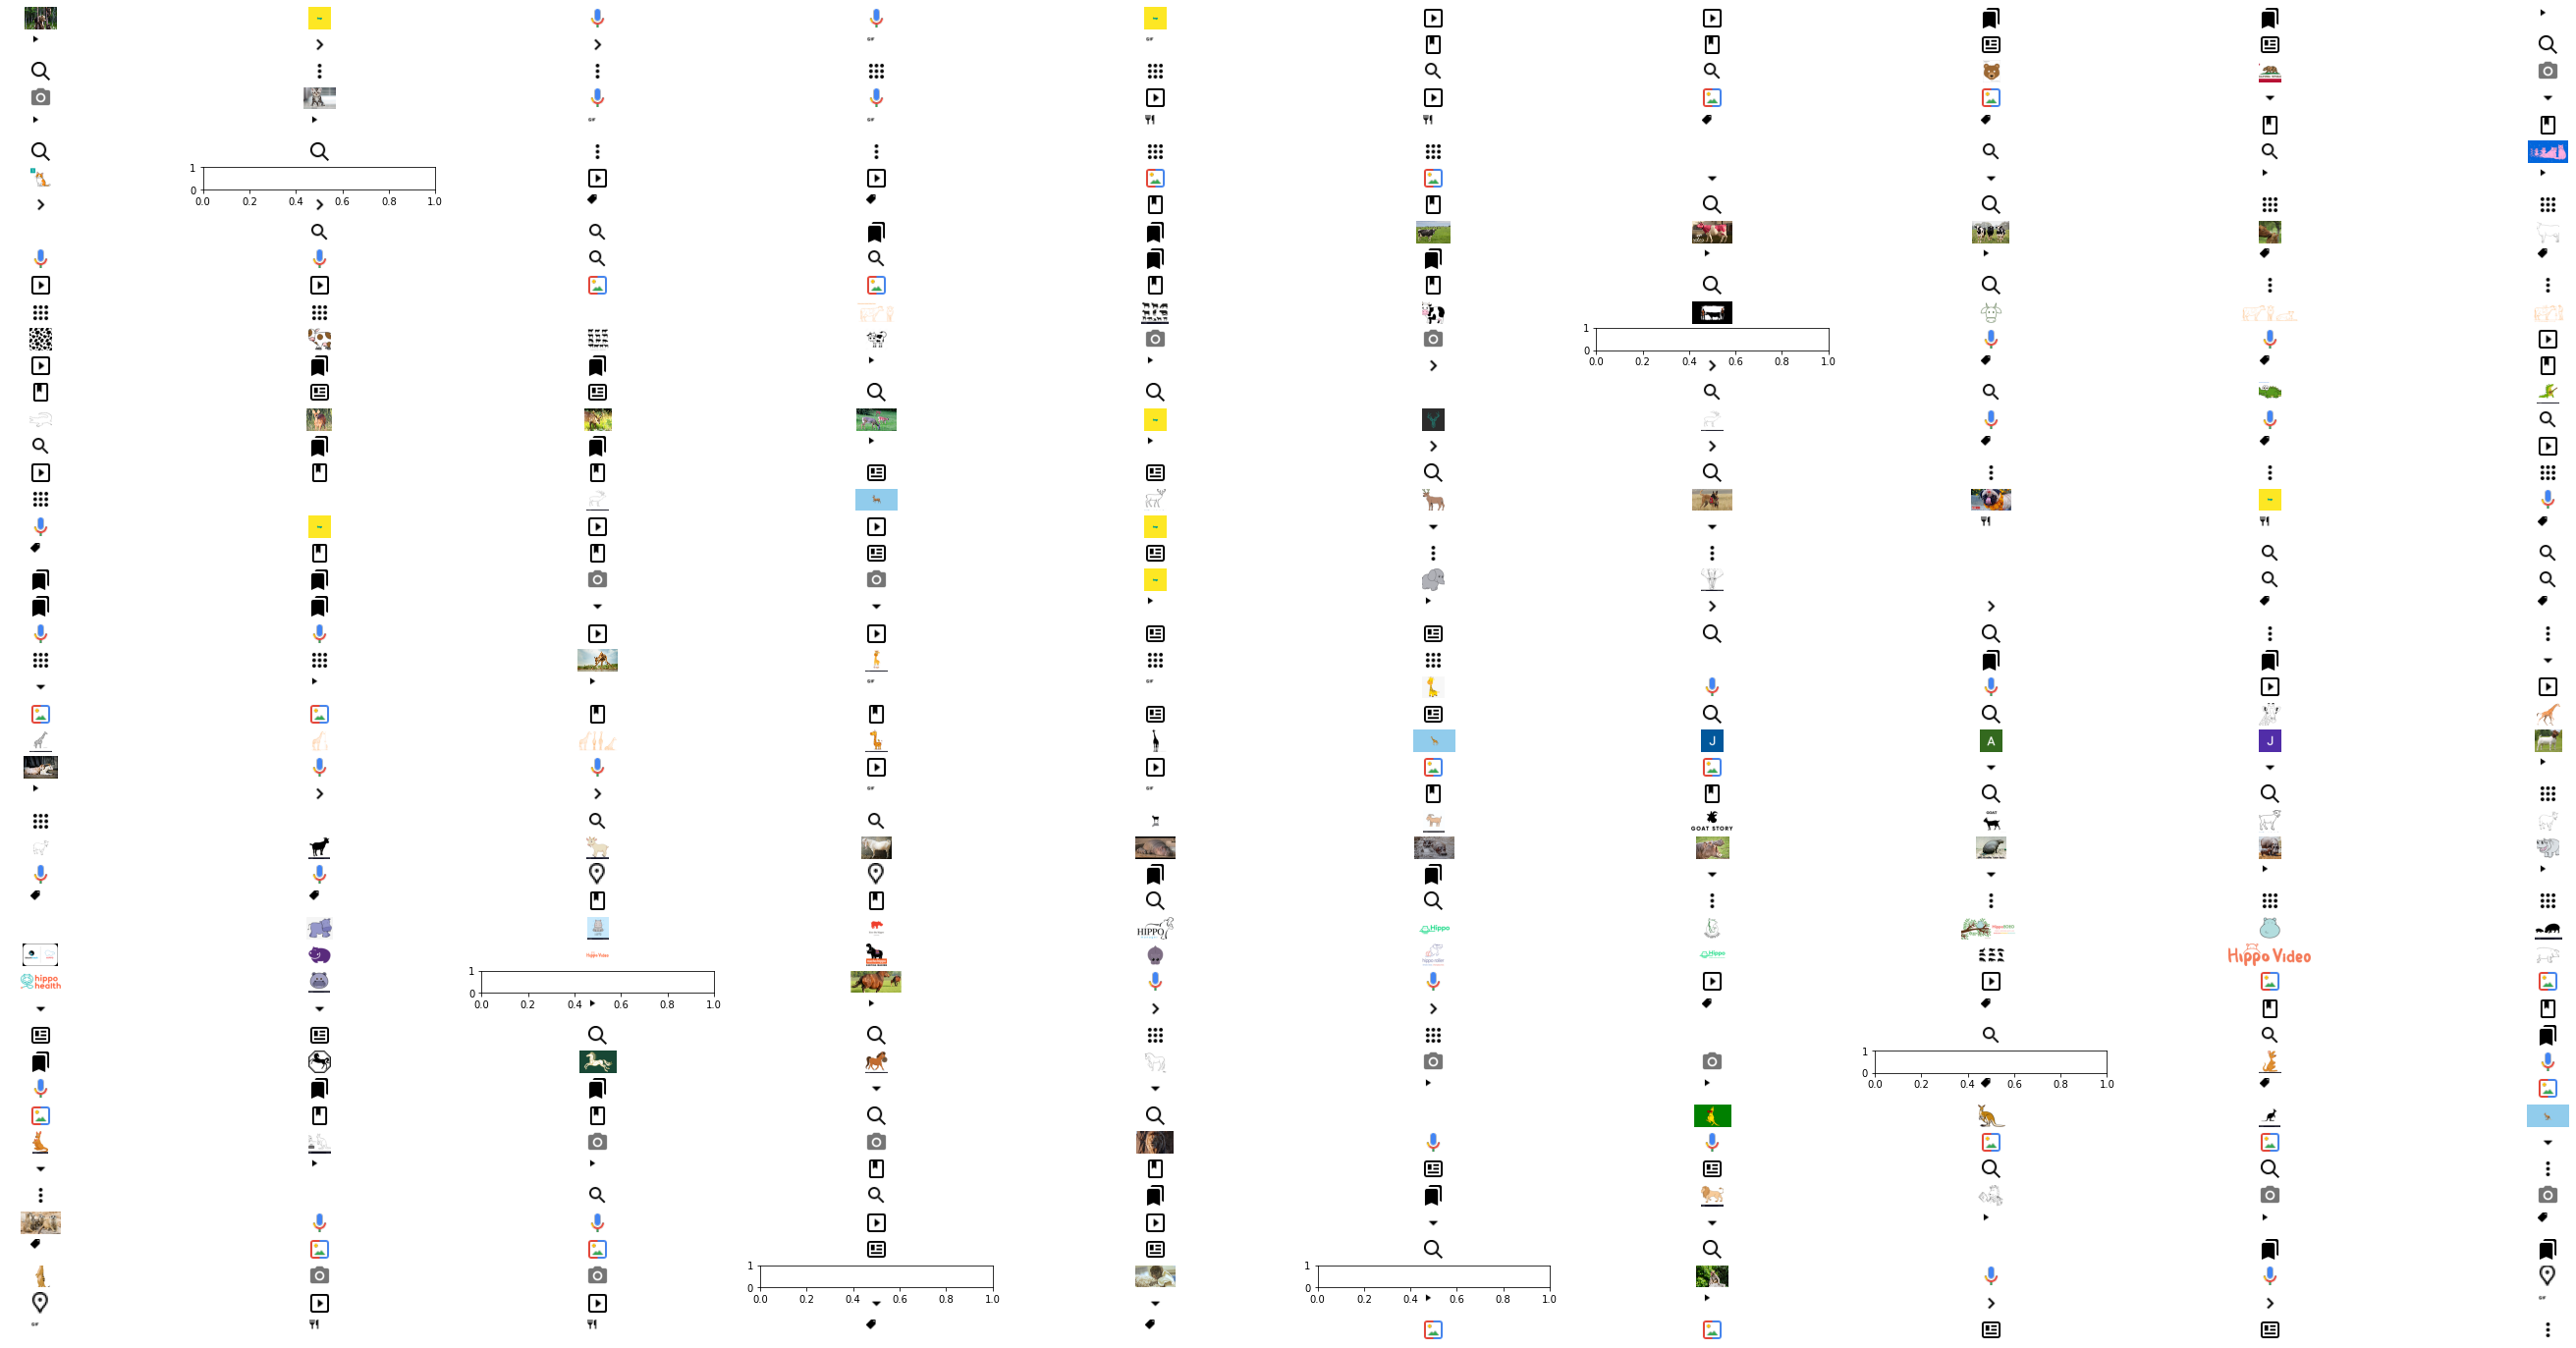

In [15]:
# Plotting 500 bad images
plt.figure(figsize=(50, 25))
for i in range(500):
    try:
        filepath = bad_images[i]
        plt.subplot(50, 10, i+1)
        plt.imshow(plt.imread(filepath))
        plt.axis(False);
    except:
        print(f'{i} - {filepath} is a defective image.')

There are defective images which are not readable by the matplotlib and it states that the format is a wrong one(mostly png images are defective). 

Then there are images which are icons or emojis and rest are images with format of CMYK and some of them with no color channels.

In [16]:
# Delete all the bad images
print('Deleting all Bad Images.')
for i in tqdm(bad_images):
    try:
        os.remove(i)
    except:
        print(f'[EXCEPTION] "{i}": Image is also Deleted')

Deleting all Bad Images.


  0%|          | 0/1330 [00:00<?, ?it/s]

[EXCEPTION] "data/animal30/raw-animals-image-dataset/train/BEAR/image0.png": Image is also Deleted
[EXCEPTION] "data/animal30/raw-animals-image-dataset/train/BEAR/image1.png": Image is also Deleted
[EXCEPTION] "data/animal30/raw-animals-image-dataset/train/BEAR/image10.png": Image is also Deleted
[EXCEPTION] "data/animal30/raw-animals-image-dataset/train/BEAR/image12.png": Image is also Deleted
[EXCEPTION] "data/animal30/raw-animals-image-dataset/train/BEAR/image13.png": Image is also Deleted
[EXCEPTION] "data/animal30/raw-animals-image-dataset/train/BEAR/image14.png": Image is also Deleted
[EXCEPTION] "data/animal30/raw-animals-image-dataset/train/BEAR/image3.png": Image is also Deleted
[EXCEPTION] "data/animal30/raw-animals-image-dataset/train/BEAR/image4.png": Image is also Deleted
[EXCEPTION] "data/animal30/raw-animals-image-dataset/train/BEAR/image5.png": Image is also Deleted
[EXCEPTION] "data/animal30/raw-animals-image-dataset/train/BEAR/image6.png": Image is also Deleted
[EXCEP

We have now cleaned the dataset and the dataset is ready for the deployment stage. 

**[INFO]** Deployment of the model and all the experiment are in the "Animal Vision - Deployment.ipynb" notebook. 